# Machine learning: Traffic sign recognition
## Hendrik Janter - R075 11 23
## Yari Nys - R076 37 29

## contents
* Predict classification for pictures in folder "Images_to_classify" using an already saved model
* General setup
* Build model
* Train model
* Visualize and evaluate results
* Optimization of hyperparameters using Keras.tuner
* Further uptimize current best model

## Predict classification for pictures in folder "Images_to_classify" using an already saved model

In [18]:
import os
from PIL import Image
from PIL import ImageOps
import numpy as np
from tensorflow import keras

model = keras.models.load_model("saved_model")

for f in os.listdir('./Images_to_classify/'):
    image3d_list = []
    image = Image.open('./Images_to_classify/' + f, 'r')
    image = image.resize((30, 30), Image.ANTIALIAS)
    image = ImageOps.grayscale(image)
    image = np.asarray(image.getdata())
    image3d_list.append(image.reshape(30, 30, 1))
    image3d = np.asarray(image3d_list)
    print("---------------" + f + "---------------")
    print(np.argmax(model.predict(image3d)))

---------------00144.png---------------
17
---------------00145.png---------------
25
---------------00146.png---------------
2
---------------00147.png---------------
9
---------------00148.png---------------
11
---------------00149.png---------------
21
---------------00150.png---------------
5
---------------00151.png---------------
24
---------------00152.png---------------
11
---------------00153.png---------------
25
---------------00154.png---------------
17
---------------00155.png---------------
3
---------------00156.png---------------
6
---------------00157.png---------------
9
---------------00158.png---------------
7
---------------00159.png---------------
4
---------------00160.png---------------
13
---------------00161.png---------------
16
---------------00162.png---------------
4
---------------00163.png---------------
25
---------------00164.png---------------
18
---------------00165.png---------------
9
---------------00166.png---------------
13
---------------00167.

## General setup
### Imports

In [3]:
#Imports for reading in and converting images.
import numpy as np

#Import for training and visualising models.
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import matplotlib.pyplot as plt

#Imports for optimisation of models.
from keras_tuner.tuners import RandomSearch

### Reading in data.

In [4]:
# Only run this the first time you load in the data.
# This block of code will store all picture data (already converted to CSV) in memory that stays across sessions.

# Load all training data (both RGB and grayscale) and normalise it.
X = np.loadtxt("DataTrafficSigns.csv", delimiter=';')/255.0
XGrayScale = np.loadtxt("DataTrafficSignsGrayScale.csv", delimiter=';')/255.0
yBinary = np.loadtxt("yBinary.csv", delimiter=';')
yLabels = np.loadtxt("y.csv", delimiter=';')

# Load all test set data (both RGB and grayscale) and normalise it.
testSet = np.loadtxt("DataTrafficSignsTest.csv", delimiter=";")/255.0
testSetGrayScale = np.loadtxt("DataTrafficSignsTestGrayScale.csv", delimiter=";")/255.0
testSetLabels = np.loadtxt("ytest.csv", delimiter=";")
testSetLabelsBinary = np.loadtxt("ytestBinary.csv", delimiter=";")

# Split test set data in cross-validation set and test set.
cvSet = np.array_split(testSet,2)[0]
testSet = np.array_split(testSet,2)[1]

cvSetGrayScale = np.array_split(testSetGrayScale, 2)[0]
testSetGrayScale = np.array_split(testSetGrayScale, 2)[1]

cvSetLabelsBinary = np.array_split(testSetLabelsBinary,2)[0]
testSetLabelsBinary = np.array_split(testSetLabelsBinary,2)[1]

cvSetLabels = np.array_split(testSetLabels,2)[0]
testSetLabels = np.array_split(testSetLabels,2)[1]

# Store all data you just loaded.
%store X
%store XGrayScale
%store yBinary
%store yLabels

%store testSet
%store testSetGrayScale
%store testSetLabels
%store testSetLabelsBinary

%store cvSet
%store cvSetGrayScale
%store cvSetLabelsBinary
%store cvSetLabels

Stored 'X' (ndarray)
Stored 'XGrayScale' (ndarray)
Stored 'yBinary' (ndarray)
Stored 'yLabels' (ndarray)
Stored 'testSet' (ndarray)
Stored 'testSetGrayScale' (ndarray)
Stored 'testSetLabels' (ndarray)
Stored 'testSetLabelsBinary' (ndarray)
Stored 'cvSet' (ndarray)
Stored 'cvSetGrayScale' (ndarray)
Stored 'cvSetLabelsBinary' (ndarray)
Stored 'cvSetLabels' (ndarray)


In [15]:
# Run this if all data has already been stored and you want to reuse it after closing the program.
# You can also run this to check if your data has been loaded correctly.

# Load all data from existing memory.
%store -r X
%store -r XGrayScale
%store -r yLabels
%store -r yBinary

%store -r testSet
%store -r testSetGrayScale
%store -r testSetLabels
%store -r testSetLabelsBinary

%store -r cvSet
%store -r cvSetGrayScale
%store -r cvSetLabelsBinary
%store -r cvSetLabels

%store -r X3d
%store -r cvSet3d
%store -r testSet3d

# Check if all data is correctly loaded in.
print("Data should be (39209,2700): " + str(X.shape))
print("Data grayscale should be (39209,900): " + str(XGrayScale.shape))
print("yBinary should be (39209,43): " + str(yBinary.shape))
print("yLabels should be (39209,): " + str(yLabels.shape))
print()
print("CV set should be (6315, 2700): "+ str(cvSet.shape))
print("CV set should be (6315, 900): "+ str(cvSetGrayScale.shape))
print("CV set binary should be (6315,43): "+ str(cvSetLabelsBinary.shape))
print("CV set labels should be (6315,): "+ str(cvSetLabels.shape))
print()
print("Test set should be (6315, 2700): "+ str(testSet.shape))
print("Test set grayscale should be (6315, 900): "+ str(testSetGrayScale.shape))
print("Test set binary should be (6315,43): "+ str(testSetLabelsBinary.shape))
print("Test set labels should be (6315,): "+ str(testSetLabels.shape))
print()
print("X3d should be (39209, 30, 30, 1): " + str(X3d.shape))
print("cvSetX3d should be (6315, 30, 30, 1): " + str(cvSet3d.shape))
print("testSetX3d should be (6315, 30, 30, 1): " + str(testSet3d.shape))

Data should be (39209,2700): (39209, 2700)
Data grayscale should be (39209,900): (39209, 900)
yBinary should be (39209,43): (39209, 43)
yLabels should be (39209,): (39209,)

CV set should be (6315, 2700): (6315, 2700)
CV set should be (6315, 900): (6315, 900)
CV set binary should be (6315,43): (6315, 43)
CV set labels should be (6315,): (6315,)

Test set should be (6315, 2700): (6315, 2700)
Test set grayscale should be (6315, 900): (6315, 900)
Test set binary should be (6315,43): (6315, 43)
Test set labels should be (6315,): (6315,)

X3d should be (39209, 30, 30, 1): (39209, 30, 30, 1)
cvSetX3d should be (6315, 30, 30, 1): (6315, 30, 30, 1)
testSetX3d should be (6315, 30, 30, 1): (6315, 30, 30, 1)


### If available load previous model and skip the "build model" and "train model"-steps.

In [5]:
model = keras.models.load_model("saved_model")

## Build model
### Reshape data to correct input matrix

In [13]:
# Convolutional layers expects a 3D matrix of pixels. reshape every row(900 values) to 30x30x1
X3d_list = []
cvSet3d_list = []
testSet3d_list = []

for i in range(XGrayScale.shape[0]):
    X3d_list.append(XGrayScale[i].reshape(30,30,1))

for i in range(cvSetGrayScale.shape[0]):
    cvSet3d_list.append(cvSetGrayScale[i].reshape(30,30,1))
    testSet3d_list.append(testSetGrayScale[i].reshape(30,30,1))

X3d = np.asarray(X3d_list)
cvSet3d = np.asarray(cvSet3d_list)
testSet3d = np.asarray(testSet3d_list)

# Store the data in its new form
%store testSet3d
%store X3d
%store cvSet3d

Stored 'testSet3d' (ndarray)
Stored 'X3d' (ndarray)
Stored 'cvSet3d' (ndarray)


### Create model by adding layers to it

In [5]:
model = Sequential()                                                # We use a sequential model
model.add(Conv2D(32,3,activation='relu', input_shape=(30,30,1)))    # Add input layer (convolutional layer)
model.add(MaxPool2D())                                              # Add max pool layer
model.add(Dropout(0.3))                                             # Add dropout layer
model.add(Conv2D(32,3,activation='relu'))                           # Add convolutional layer
model.add(MaxPool2D())                                              # Add max pool layer
model.add(Dropout(0.6))                                             # Add dropout layer
model.add(Flatten())                                                # Add flatten layer
model.add(Dense(43, activation='softmax'))                          # Add output layer (dense layer)

### Compile the created model.

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(),  # We use the optimizer called Adam
    loss='categorical_crossentropy',    # We use this loss function
    metrics=['accuracy'],           # We will optimize towards a high cross validation accuracy
)

## Train model
### Run training algorithm

In [7]:
history = model.fit(
    X3d,                                            # training data
    yBinary,                                        # training targets
    validation_data=(cvSet3d, cvSetLabelsBinary),   # Cross validation data and targets
    epochs=50,                                      # Number of runs through the complete training set
    batch_size=32,                                  # Number of training samples iterated before updating the model
)

Epoch 1/50
1226/1226 [==============================] - 18s 13ms/step - loss: 1.7946 - accuracy: 0.5121 - val_loss: 0.7876 - val_accuracy: 0.8181
Epoch 2/50
1226/1226 [==============================] - 16s 13ms/step - loss: 0.6013 - accuracy: 0.8270 - val_loss: 0.4943 - val_accuracy: 0.8887
Epoch 3/50
1226/1226 [==============================] - 15s 13ms/step - loss: 0.4143 - accuracy: 0.8817 - val_loss: 0.4248 - val_accuracy: 0.9036
Epoch 4/50
1226/1226 [==============================] - 14s 12ms/step - loss: 0.3262 - accuracy: 0.9053 - val_loss: 0.3393 - val_accuracy: 0.9139
Epoch 5/50
1226/1226 [==============================] - 14s 12ms/step - loss: 0.2809 - accuracy: 0.9172 - val_loss: 0.2917 - val_accuracy: 0.9297
Epoch 6/50
1226/1226 [==============================] - 17s 14ms/step - loss: 0.2451 - accuracy: 0.9283 - val_loss: 0.2624 - val_accuracy: 0.9354
Epoch 7/50
1226/1226 [==============================] - 16s 13ms/step - loss: 0.2200 - accuracy: 0.9347 - val_loss: 0.2903 -

### Save the trained model to use even after closing the program

In [35]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


## Visualize and evaluate results
### Plot learning curve and cost function

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


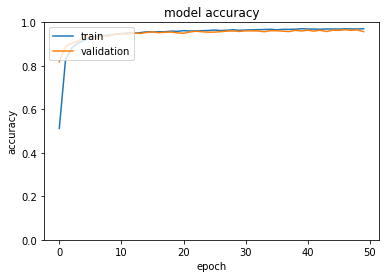

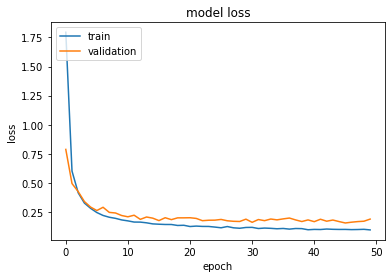

In [8]:
# summarize history for accuracy
print(history.history.keys())
plt.ylim(0,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluate model accuracy on test set

In [47]:
print(model.evaluate(testSet3d, testSetLabelsBinary))

198/198 [==============================] - 9s 26ms/step - loss: 0.1429 - accuracy: 0.9769
[0.14290793240070343, 0.9768804311752319]


## Optimization of hyperparameters using Keras.tuner
### Make the function to build the model

In [83]:
def build_model(hp):
    optimization_model = Sequential()
    # We will optimize the number of input units.
    optimization_model.add(Conv2D(hp.Int("input_units", min_value=32, max_value=256, step=32),3,activation='relu', input_shape=(30,30,1)))
    optimization_model.add(MaxPool2D())

    # We will optimize the number of hidden convolutional layers.
    for i in range(hp.Int("number_hidden_layers", 1, 4)):
        optimization_model.add(Dropout(0.3))
        # We will optimize the number of nodes in the hidden convolutional layers.
        optimization_model.add(Conv2D(hp.Int(f"conv_{i}_units", min_value=32, max_value=256, step=32),3,activation='relu'))

    optimization_model.add(Dropout(0.6))
    optimization_model.add(Flatten())
    optimization_model.add(Dense(43, activation='softmax'))

    optimization_model.compile(
        # We will optimize the learning rate.
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return optimization_model

### Build a tuner object to use for optimization

In [84]:
tuner = RandomSearch(build_model,       # Function used to build the models
             objective='val_accuracy',  # We will train towards cross-validation set accuracy.
             max_trials=10,             # We will train ten models with different yet random parameters as defined in build_model.
             executions_per_trial=1,    # We will train every model only once (not multiple times to reduce the effect of randomness since it would take to long to train).
             )

In [85]:
tuner.search_space_summary()            # Shows all parameters we will optimize in tuner and their possible values.

Search space summary
Default search space size: 4
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
n_layers-1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


### Run optimization algorithm

In [86]:
tuner.search(
    X3d,                                            # Training data
    yBinary,                                        # Training targets
    validation_data=(cvSet3d, cvSetLabelsBinary),   # Cross-validation data and targets
    epochs=40,                                      # Number of times we will go through all training data for every model
    batch_size=32,                                  # The amount of training samples iterated before updating model parameters
)

best_model = tuner.get_best_models()[0]             # Returns the best model from the optimization session

Trial 10 Complete [00h 34m 15s]
val_accuracy: 0.059382423758506775

Best val_accuracy So Far: 0.9754552841186523
Total elapsed time: 12h 43m 07s
INFO:tensorflow:Oracle triggered exit


### Show results of optimization

In [87]:
print(tuner.get_best_models()[0].summary())         # Gives information about best model.
print("-----------------------------------------")
print(tuner.get_best_hyperparameters()[0].values)   # Shows hyperparameters for best model
print("-----------------------------------------")
tuner.results_summary()                             # Ranks first ten models from best to worst

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 224)       2240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 224)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 224)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 224)       451808    
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 224)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        64544     
                                                        

## Further optimize current best model
### Make a function to build the optimal model

In [27]:
def build_optimal_model():
    optimalModel = Sequential()
    optimalModel.add(Conv2D(224,3,activation='relu', input_shape=(30,30,1)))
    optimalModel.add(MaxPool2D())
    optimalModel.add(Dropout(0.3))
    optimalModel.add(Conv2D(224,3,activation='relu'))
    optimalModel.add(Dropout(0.3))
    optimalModel.add(Conv2D(32,3,activation='relu'))
    optimalModel.add(Dropout(0.3))
    optimalModel.add(Conv2D(32,3,activation='relu'))
    optimalModel.add(Dropout(0.6))
    optimalModel.add(Flatten())
    optimalModel.add(Dense(43, activation='softmax'))

    optimalModel.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return optimalModel

### Optimize number of epochs and batch size

In [28]:
results = np.empty(shape=(9, 2), dtype='object')                # Make variable to store results in.
index = 0                                                       # Variable to keep track of the model being trained.
for epochs in range(30, 51, 10):                                # We're checking 30, 40 and 50 epochs.
    for batch_size_multiplier in range(3):                      # We're checking a batch size of 32, 64 and 128.
        print("Training model " + str(index) + ".")             # Make a print to keep track of the model being trained throughout .
        test_model = build_optimal_model()                      # Make the model using the function build_optimal_model.
        history = test_model.fit(                               # Train the model.
            X3d,                                                # Training data
            yBinary,                                            # Training targets
            validation_data=(cvSet3d, cvSetLabelsBinary),       # Cross-validation data and targets
            epochs=epochs,
            batch_size= 32+32*batch_size_multiplier,
        )
                                                                # Save the data for the trained model
        model.save("saved_model_" + str(index))
        results[index][0] = history
        results[index][1] = history.history['val_accuracy'][-1]
        index += 1

Training model 0.
Epoch 1/30
1226/1226 [==============================] - 170s 138ms/step - loss: 1.1148 - accuracy: 0.6905 - val_loss: 0.3184 - val_accuracy: 0.9140
Epoch 2/30
1226/1226 [==============================] - 168s 137ms/step - loss: 0.2361 - accuracy: 0.9308 - val_loss: 0.2420 - val_accuracy: 0.9387
Epoch 3/30
1226/1226 [==============================] - 168s 137ms/step - loss: 0.1562 - accuracy: 0.9523 - val_loss: 0.2048 - val_accuracy: 0.9485
Epoch 4/30
1226/1226 [==============================] - 167s 137ms/step - loss: 0.1223 - accuracy: 0.9630 - val_loss: 0.1905 - val_accuracy: 0.9533
Epoch 5/30
1226/1226 [==============================] - 168s 137ms/step - loss: 0.0999 - accuracy: 0.9706 - val_loss: 0.1692 - val_accuracy: 0.9563
Epoch 6/30
1226/1226 [==============================] - 165s 135ms/step - loss: 0.0880 - accuracy: 0.9733 - val_loss: 0.1596 - val_accuracy: 0.9596
Epoch 7/30
1226/1226 [==============================] - 164s 133ms/step - loss: 0.0812 - accur

In [39]:
for i in range(9):
    print(str(i) + ":\nval_accuracy: " + str(results[i][1]))
    print("max val_accuracy during training: " + str(max(results[i][0].history['val_accuracy'])))

0:
val_accuracy: 0.9710213541984558
max val_accuracy during training: 0.9726049304008484
1:
val_accuracy: 0.9770388007164001
max val_accuracy during training: 0.9770388007164001
2:
val_accuracy: 0.9713380932807922
max val_accuracy during training: 0.972288191318512
3:
val_accuracy: 0.9703879356384277
max val_accuracy during training: 0.9751385450363159
4:
val_accuracy: 0.9743468165397644
max val_accuracy during training: 0.9743468165397644
5:
val_accuracy: 0.9765637516975403
max val_accuracy during training: 0.9765637516975403
6:
val_accuracy: 0.9700712561607361
max val_accuracy during training: 0.9764053821563721
7:
val_accuracy: 0.9776722192764282
max val_accuracy during training: 0.9776722192764282
8:
val_accuracy: 0.9764053821563721
max val_accuracy during training: 0.980997622013092


### Visualize learning curve and cost function for all models

Model 0
val_accuracy: 0.9710213541984558
max val_accuracy during training: 0.9726049304008484


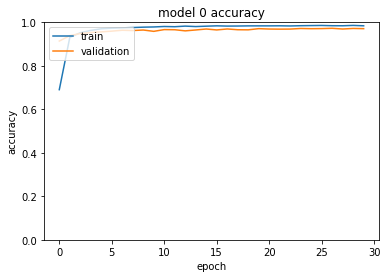

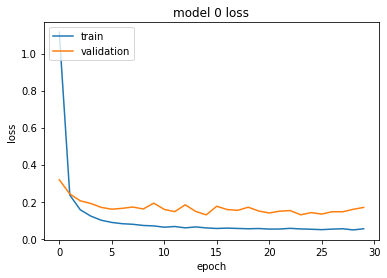

Model 1
val_accuracy: 0.9770388007164001
max val_accuracy during training: 0.9770388007164001


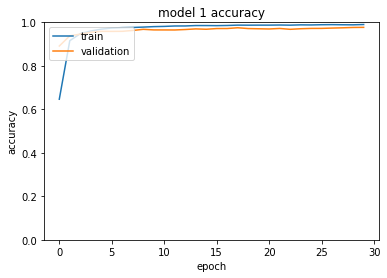

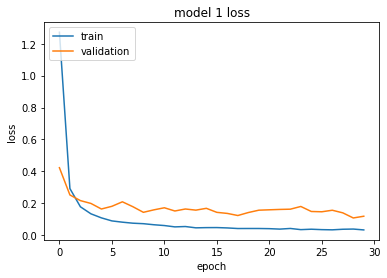

Model 2
val_accuracy: 0.9713380932807922
max val_accuracy during training: 0.972288191318512


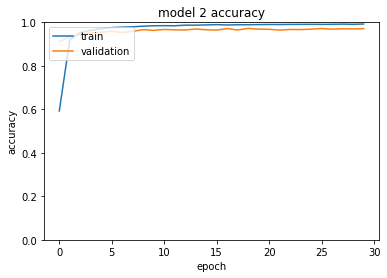

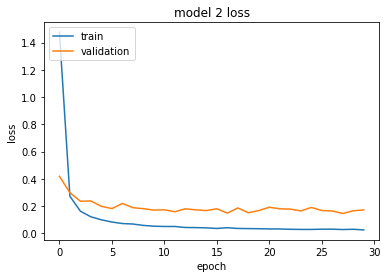

Model 3
val_accuracy: 0.9703879356384277
max val_accuracy during training: 0.9751385450363159


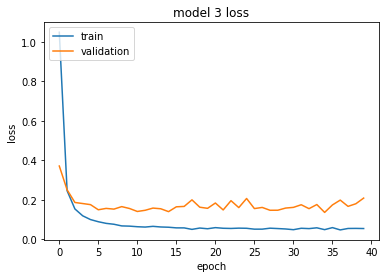

Model 4
val_accuracy: 0.9743468165397644
max val_accuracy during training: 0.9743468165397644


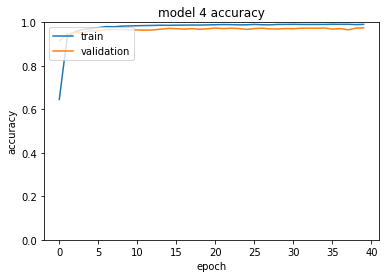

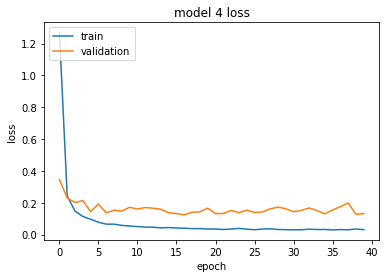

Model 5
val_accuracy: 0.9765637516975403
max val_accuracy during training: 0.9765637516975403


Model 6
val_accuracy: 0.9700712561607361
max val_accuracy during training: 0.9764053821563721


Model 7
val_accuracy: 0.9776722192764282
max val_accuracy during training: 0.9776722192764282


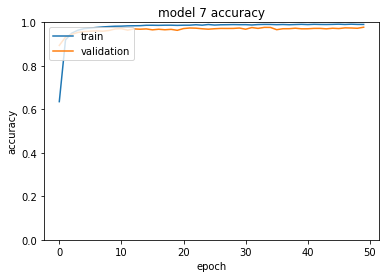

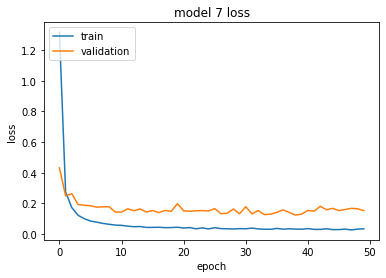

Model 8
val_accuracy: 0.9764053821563721
max val_accuracy during training: 0.980997622013092


In [45]:
for i in range(9):
    # summarize history for accuracy
    print("Model " + str(i))
    print("val_accuracy: " + str(results[i][1]))
    print("max val_accuracy during training: " + str(max(results[i][0].history['val_accuracy'])))
    plt.ylim(0,1)
    plt.plot(results[i][0].history['accuracy'])
    plt.plot(results[i][0].history['val_accuracy'])
    plt.title('model ' + str(i) + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(results[i][0].history['loss'])
    plt.plot(results[i][0].history['val_loss'])
    plt.title('model ' + str(i) + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()